## **Import Library**

In [1]:
# !pip install emoji
# !pip install transformer

In [ ]:
import matplotlib.pyplot as plt
import opendatasets as od
import seaborn as sns
import pandas as pd
import tensorflow as tf

import numpy as np
import re
import string
import nltk

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Model, Sequential, callbacks
from nltk.corpus import stopwords
from matplotlib import style

style.use("ggplot")

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

In [ ]:
od.download("https://www.kaggle.com/datatattle/covid-19-nlp-text-classification")

## **Exploratory Data Analysis**

In [4]:
df_train = pd.read_csv("covid-19-nlp-text-classification/Corona_NLP_train.csv", encoding='latin-1')
print(f'Jumlah Dataset : {len(df_train)}\n')
df_train.sample(5)

Jumlah Dataset : 41157



,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
4759,8558,53510,NaN,18-03-2020,Confirmed #coronavirus symptoms: advised by do...,Neutral
3576,7375,52327,Singapore,18-03-2020,@itvnews #Coronavirus idea: Should someone inv...,Positive
25413,29212,74164,"Manchester, UK",31-03-2020,Fridge situation critical. Might have to ventu...,Extremely Negative
12926,16725,61677,"Los Angeles, CA",21-03-2020,Covidiot (noun) /co-vid-ee-ut/\r\r\nhoarders o...,Negative
23243,27042,71994,"Kerala, India",25-03-2020,Both Kerala Govt amp NDA Govt Don t Have Money...,Extremely Negative


In [5]:
df_test = pd.read_csv("covid-19-nlp-text-classification/Corona_NLP_train.csv", encoding='latin-1')
df_test.sample(5)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
24978,28777,73729,"Ajman, United Arab Emirates",29-03-2020,Lulu hypermarket revises timings launches prio...,Neutral
9743,13542,58494,St. Louis * Cologne,20-03-2020,"In the Covid-19 hysteria, I've learned a new G...",Extremely Negative
26719,30518,75470,Illinois,02-04-2020,Is this what you are waiting for How many more...,Positive
16774,20573,65525,"Bremerton, WA",22-03-2020,New post ('$7 for lettuce is ridiculous': Frui...,Extremely Negative
5983,9782,54734,"Norwich, England",19-03-2020,Coronavirus: What's your #supermarket doing to...,Extremely Negative


In [6]:
df_train = df_train[['OriginalTweet', 'Sentiment']]
df_train.head()

,OriginalTweet,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [7]:
df_test = df_test[['OriginalTweet', 'Sentiment']]
df_test.head()

,OriginalTweet,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative


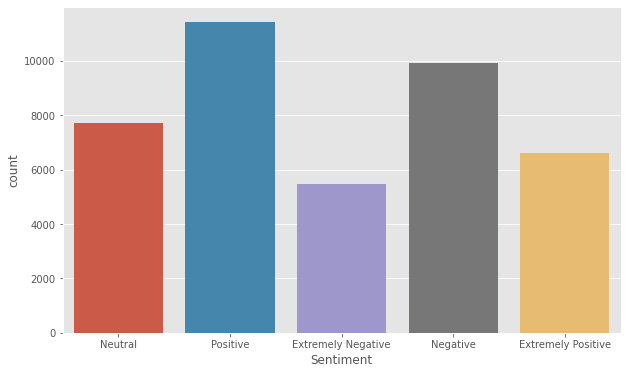

In [8]:
plt.figure(figsize=(10,6))
sns.countplot(x='Sentiment', data=df_train)
plt.show()

## **Preprocessing Data**

In [9]:
lemmatizer = nltk.stem.WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def cleansing(text):
    # Memisahkan Kata Singkatan (Abbreviaton). Contoh won't -> will not 
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)

    # Mengubah setiap kata menjadi lowercase
    text =  text.lower() 

    # Menghapus Link Dengan Pattern http/https dan www
    text = re.sub(r'http\S+', '', text)
    text = re.sub('(@\w+|#\w+)', '', text)

    # Menghapus Tag HTML
    text = re.sub('<.*?>', '', text)

    # Menghapus Tanda Baca Seperti Titik Dan Koma
    text = text.translate(str.maketrans(' ', ' ', string.punctuation))

    # Menghapus Karakter Selain Huruf a-z dan A-Z
    text = re.sub('[^a-zA-Z]', ' ', text)

    # Mengganti baris baru (enter) dengan spasi
    text = re.sub("\n", " ", text)

    # Menghapus Karakter Berulang (Contoh: Horeeee!!!! menjadi Hore!)
    text = re.sub(r'(\w)(\1{2,})', r"\1", text)

    # Menghapus 1 Karakter Terpisah
    text = re.sub(r"\b[a-zA-Z]\b", "", text)

    # Menghapus Spasi Yang Lebih Dari Satu
    text = re.sub('(s{2,})', ' ', text)
    
    # Menghapus kata yang mengandung judul topik dan kata yang terdapat pada stopwords nltk 
    temp_text_split = []
    text_split = text.split(' ')

    for i in range(len(text_split)):
        if text_split[i] not in stop_words and len(text_split) > 3:
            temp_text_split.append(text_split[i])
    
    temp_text_split = list(set(temp_text_split))
    text = ' '.join(temp_text_split)
    
    # Mengembalikan Hasil Preprocessing Text
    return str.lstrip(text)


df_train['text'] = df_train['OriginalTweet'].apply(cleansing)
df_test['text'] = df_test['OriginalTweet'].apply(cleansing)

In [10]:
df_train['text'].sample(5).values

array(['think week bankruptcy gotten control shopping past waived get new jordan online way',
       'ny grocery current hudson state store valley',
       'week stores closed us coronavirus',
       'first grocery times higher come allow good store preference elderly risk move people given local',
       'rid huh anywhere catch soon buy gotten perfect ca really city prices time due house drop depending also market break estimated covid job housing millenials even'],
      dtype=object)

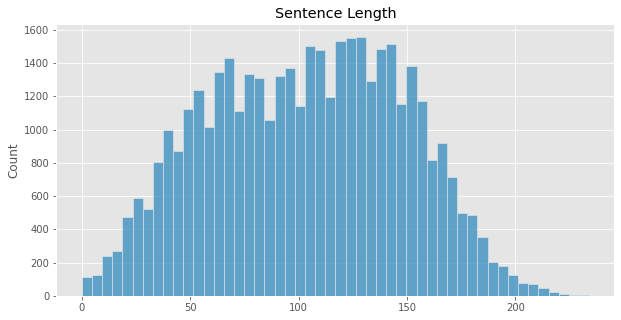

In [71]:
plt.figure(figsize=(10, 5))
sns.histplot([len(s) for s in df_train.text], bins=50)
plt.title('Sentence Length')
plt.show()

In [12]:
map_categorical = {
    "Neutral" : 0, 
    "Positive": 1, 
    "Extremely Positive": 2, 
    "Negative": 3, 
    "Extremely Negative": 4
}

df_test["label"] = df_test["Sentiment"].map(map_categorical)
df_train["label"] = df_train["Sentiment"].map(map_categorical)

In [13]:
df_test.drop(columns=["OriginalTweet", "Sentiment"], axis=1, inplace=True)
df_train.drop(columns=["OriginalTweet", "Sentiment"], axis=1, inplace=True)

In [14]:
!nvidia-smi -L

GPU 0: A100-SXM4-40GB (UUID: GPU-42307e29-459e-0f8a-4ec7-a32ddbc65184)


## **Tokenisasi Dataset**

In [35]:
max_features = 100000

token = Tokenizer(num_words=max_features, split = ' ')
token.fit_on_texts(df_train['text'].values)

x = token.texts_to_sequences(df_train['text'].values)
x = pad_sequences(x, maxlen=50, padding='pre')
x

array([[    0,     0,     0, ...,     0,     0,     0],
       [    0,     0,     0, ...,   848,   754,   387],
       [    0,     0,     0, ...,  1563,    71,    20],
       ...,
       [    0,     0,     0, ..., 35612,    15,    42],
       [    0,     0,     0, ...,  3769,    26,   572],
       [    0,     0,     0, ...,   126,   268,    87]], dtype=int32)

In [36]:
y = pd.get_dummies(df_train['label']).values

## **Train Test Split**

In [37]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=0, stratify=df_train['label'])

## **Membuat Model LSTM**

In [38]:
from keras.models import Sequential
from keras.layers import Embedding, Dense, LSTM, Dropout, Bidirectional

In [39]:
model = Sequential()

model=Sequential()
model.add(Embedding(max_features, 128, input_length=50))
model.add(Bidirectional(LSTM(500)))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(5,activation='softmax'))

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 50, 128)           12800000  
                                                                 
 bidirectional_3 (Bidirectio  (None, 1000)             2516000   
 nal)                                                            
                                                                 
 dense_9 (Dense)             (None, 256)               256256    
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_10 (Dense)            (None, 512)               131584    
                                                                 
 dropout_7 (Dropout)         (None, 512)               0         
                                                      

In [40]:
METRICS = [
    tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc'),
]

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=METRICS
)

## **Train Model**

In [41]:
early_stopping = callbacks.EarlyStopping(
    monitor ="val_loss", 
    mode ="min", patience=3
)

history = model.fit(
    x_train, y_train,
    epochs=50, 
    validation_data=(x_val, y_val),
    callbacks=[early_stopping], 
    batch_size = 64,
)

Epoch 1/50
515/515 [==============================] - 8s 12ms/step - loss: 1.1239 - accuracy: 0.5298 - precision: 0.6881 - recall: 0.3347 - auc: 0.8358 - val_loss: 0.7839 - val_accuracy: 0.7081 - val_precision: 0.7441 - val_recall: 0.6589 - val_auc: 0.9216
Epoch 2/50
515/515 [==============================] - 5s 10ms/step - loss: 0.6213 - accuracy: 0.7778 - precision: 0.8007 - recall: 0.7406 - auc: 0.9498 - val_loss: 0.7238 - val_accuracy: 0.7430 - val_precision: 0.7647 - val_recall: 0.7102 - val_auc: 0.9340
Epoch 3/50
515/515 [==============================] - 5s 10ms/step - loss: 0.4237 - accuracy: 0.8588 - precision: 0.8747 - recall: 0.8385 - auc: 0.9752 - val_loss: 0.7874 - val_accuracy: 0.7300 - val_precision: 0.7479 - val_recall: 0.7060 - val_auc: 0.9281
Epoch 4/50
515/515 [==============================] - 5s 10ms/step - loss: 0.3137 - accuracy: 0.8968 - precision: 0.9125 - recall: 0.8826 - auc: 0.9858 - val_loss: 0.9322 - val_accuracy: 0.7194 - val_precision: 0.7382 - val_recal

## **Model Evaluation**

In [42]:
history = history.history

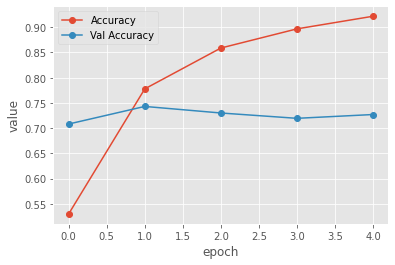

In [43]:
plt.plot(history['accuracy'], label="Accuracy", marker = "o")
plt.plot(history['val_accuracy'], label="Val Accuracy", marker = "o")
plt.xlabel("epoch")
plt.ylabel("value")
plt.legend()
plt.show()

In [56]:
x_test = token.texts_to_sequences(df_test['text'])
x_test = pad_sequences(x_test, maxlen=50, padding='pre')

In [57]:
y_test = pd.get_dummies(df_test['label']).values

In [58]:
loss, accuracy, precision, recall, auc = model.evaluate(x_test, y_test)

1287/1287 [==============================] - 6s 4ms/step - loss: 0.3195 - accuracy: 0.9066 - precision: 0.9199 - recall: 0.8949 - auc: 0.9836


In [65]:
predict = model.predict(x_test)
predict = np.argmax(predict, axis=1)

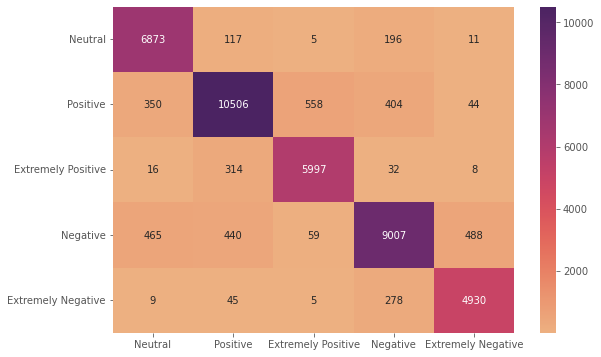


               precision    recall  f1-score   support

           0       0.89      0.95      0.92      7202
           1       0.92      0.89      0.90     11862
           2       0.91      0.94      0.92      6367
           3       0.91      0.86      0.88     10459
           4       0.90      0.94      0.92      5267

    accuracy                           0.91     41157
   macro avg       0.90      0.92      0.91     41157
weighted avg       0.91      0.91      0.91     41157



In [69]:
from sklearn.metrics import confusion_matrix,classification_report

conf_matrix = confusion_matrix(predict, df_test['label'])

plt.figure(figsize=(9, 6))
sns.heatmap(
    conf_matrix, 
    annot=True, 
    xticklabels=['Neutral', 'Positive', 'Extremely Positive', 'Negative', 'Extremely Negative'], 
    yticklabels=['Neutral', 'Positive', 'Extremely Positive', 'Negative', 'Extremely Negative'], 
    cmap='flare', fmt='d'
)
plt.show()

print("\n", classification_report(predict, df_test['label']))